In [3]:
from statsmodels.regression.rolling import RollingOLS
#import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from datetime import datetime, date
warnings.filterwarnings('ignore')

# Get SPY Data

In [4]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    "User-Agent": "Chrome/117.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)

In [5]:
df_list = pd.read_html(response.text)
sp500 = df_list[0]

In [6]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

In [7]:
end_date = datetime.now().strftime('%Y-%m-%d')
end_date = pd.to_datetime(end_date)

start_date = end_date - pd.DateOffset(365*8)

In [8]:
start_date

Timestamp('2017-10-24 00:00:00')

In [9]:
df = yf.download(tickers=symbols_list, start=start_date, end=end_date)

[*********************100%***********************]  503 of 503 completed


In [10]:
df = df.stack()
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

In [11]:
df

Price                   close        high         low        open      volume
date       ticker                                                            
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0
...                       ...         ...         ...         ...         ...
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0

[991845 rows x 5 columns]

# Calculate features and technical indicators for each stock

## Garman-Klass Volaitlity

In [12]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['close']))-np.log(df['open'])**2)

In [13]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol  
date       ticker                    
2017-10-24 A               5.046872  
           AAPL            3.607714  
           ABBV            5.205621  
           ABT             4.333528  
           ACGL            3.336822  
...                             ...  
2025-10-21 XYZ             5.574631  
           YUM             7.718556  
           ZBH             6.502109  
           ZBRA           10.372406  
           ZTS             7.637979  

[991845 rows x 6 columns]

In [14]:
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

In [15]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol        rsi  
date       ticker                               
2017-10-24 A               5.046872        NaN  
           AAPL            3.607714        NaN  
           ABBV            5.205621        NaN  
           ABT             4.333528        NaN  
           ACGL            3.336822        NaN  
...                             ...        ...  
2025-10-21 XYZ             5.574631  53.595338  
           YUM             7.718556  52.997088  
           ZBH             6.502109  56.731861  
           ZBRA           10.372406  51.278878  
           ZTS             7.637979  49.473022  

[991845 rows x 7 columns]

<Axes: xlabel='date'>

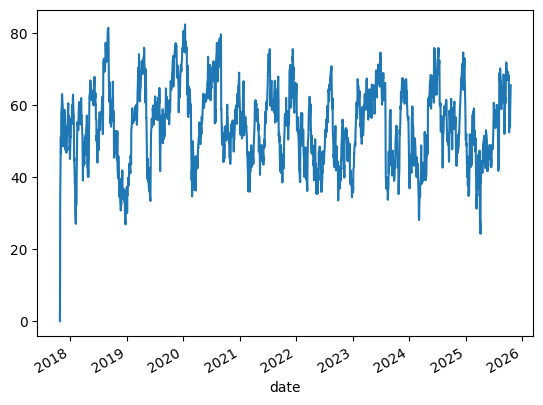

In [16]:
df.xs('AAPL', level=1)['rsi'].plot()

# Bollinger bands

In [17]:
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_upper'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [18]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  
date       ticker                                                             
2017-10-24 A               5.046872        NaN       NaN       NaN       NaN  
           AAPL            3.607714        NaN       NaN       NaN       NaN  
           ABBV            5.205621        NaN       NaN       NaN       NaN  
           ABT             4.333528        NaN       NaN       NaN       NaN  
           ACGL            3.336822        NaN       NaN       NaN       NaN  
...                             ...        ...       ...       ...       ...  
2025-10-21 XYZ             5.574631  53.595338  4.285440  4.345573  4.405705  
           YUM             7.718556  52.997088  4.946698  5.001524  5.056350  
           ZBH             6.502109  56.731861  4.561366  4.603603  4.645840  
           ZBRA           10.372406  51.278878  5.640654  5.696175  5.751696  
           ZTS             7.637979  49.473022  4.950264  4.975955  5.001646  

[991845 rows x 10 columns]

# ATR

In [19]:
def calculate_atr(stock_data):
    atr = pandas_ta.atr(
        high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14
    )

    return atr.sub(atr.mean()).div(atr.std())

In [20]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(calculate_atr)
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-24 A               5.046872        NaN       NaN       NaN       NaN   
           AAPL            3.607714        NaN       NaN       NaN       NaN   
           ABBV            5.205621        NaN       NaN       NaN       NaN   
           ABT             4.333528        NaN       NaN       NaN       NaN   
           ACGL            3.336822        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-21 XYZ             5.574631  53.595338  4.285440  4.345573  4.405705   
           YUM             7.718556  52.997088  4.946698  5.001524  5.056350   
           ZBH             6.502109  56.731861  4.561366  4.603603  4.645840   
           ZBRA           10.372406  51.278878  5.640654  5.696175  5.751696   
           ZTS             7.637979  49.473022  4.950264  4.975955  5.001646   

Price                   atr  
date       ticker            
2017-10-24 A            NaN  
           AAPL         NaN  
           ABBV         NaN  
           ABT          NaN  
           ACGL         NaN  
...                     ...  
2025-10-21 XYZ    -0.603112  
           YUM     1.045239  
           ZBH    -0.616339  
           ZBRA    0.228522  
           ZTS    -0.449419  

[991845 rows x 11 columns]

# MACD

In [21]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    
    return macd.sub(macd.mean()).div(macd.std())

In [22]:
df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

In [23]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-24 A               5.046872        NaN       NaN       NaN       NaN   
           AAPL            3.607714        NaN       NaN       NaN       NaN   
           ABBV            5.205621        NaN       NaN       NaN       NaN   
           ABT             4.333528        NaN       NaN       NaN       NaN   
           ACGL            3.336822        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-21 XYZ             5.574631  53.595338  4.285440  4.345573  4.405705   
           YUM             7.718556  52.997088  4.946698  5.001524  5.056350   
           ZBH             6.502109  56.731861  4.561366  4.603603  4.645840   
           ZBRA           10.372406  51.278878  5.640654  5.696175  5.751696   
           ZTS             7.637979  49.473022  4.950264  4.975955  5.001646   

Price                   atr      macd  
date       ticker                      
2017-10-24 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2025-10-21 XYZ    -0.603112  0.003626  
           YUM     1.045239 -0.551296  
           ZBH    -0.616339  0.094575  
           ZBRA    0.228522 -0.489170  
           ZTS    -0.449419 -0.502647  

[991845 rows x 12 columns]

# Dollar volume

In [24]:
df['dollar_volume'] = (df['close']*df['volume'])/1e6

In [25]:
df

Price                   close        high         low        open      volume  \
date       ticker                                                               
2017-10-24 A        63.377014   63.593546   62.962783   63.367598   1975700.0   
           AAPL     36.695297   36.770041   36.485074   36.506095  71028800.0   
           ABBV     65.128342   66.868599   64.474852   66.769156  10301100.0   
           ABT      48.117561   48.717075   47.943788   48.656255   7201000.0   
           ACGL     32.308361   32.514390   32.279835   32.473186   1521900.0   
...                       ...         ...         ...         ...         ...   
2025-10-21 XYZ      77.730003   78.870003   76.050003   76.239998   4350300.0   
           YUM     148.529999  149.100006  147.139999  148.139999   1491800.0   
           ZBH     102.690002  103.120003  102.129997  102.809998    800800.0   
           ZBRA    306.209991  308.630005  301.089996  301.089996    370100.0   
           ZTS     146.089996  147.270004  144.550003  144.830002   2073400.0   

Price              garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-24 A               5.046872        NaN       NaN       NaN       NaN   
           AAPL            3.607714        NaN       NaN       NaN       NaN   
           ABBV            5.205621        NaN       NaN       NaN       NaN   
           ABT             4.333528        NaN       NaN       NaN       NaN   
           ACGL            3.336822        NaN       NaN       NaN       NaN   
...                             ...        ...       ...       ...       ...   
2025-10-21 XYZ             5.574631  53.595338  4.285440  4.345573  4.405705   
           YUM             7.718556  52.997088  4.946698  5.001524  5.056350   
           ZBH             6.502109  56.731861  4.561366  4.603603  4.645840   
           ZBRA           10.372406  51.278878  5.640654  5.696175  5.751696   
           ZTS             7.637979  49.473022  4.950264  4.975955  5.001646   

Price                   atr      macd  dollar_volume  
date       ticker                                     
2017-10-24 A            NaN       NaN     125.213967  
           AAPL         NaN       NaN    2606.422929  
           ABBV         NaN       NaN     670.893560  
           ABT          NaN       NaN     346.494559  
           ACGL         NaN       NaN      49.170095  
...                     ...       ...            ...  
2025-10-21 XYZ    -0.603112  0.003626     338.148834  
           YUM     1.045239 -0.551296     221.577052  
           ZBH    -0.616339  0.094575      82.234154  
           ZBRA    0.228522 -0.489170     113.328318  
           ZTS    -0.449419 -0.502647     302.902998  

[991845 rows x 13 columns]

# Aggregate to monthly level

In [26]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low']]

In [27]:
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()

In [28]:
data

dollar_volume       close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-11-30 A          129.382349   65.184532          5.114482  57.695123   
           AAPL      4609.526609   40.284889          3.825709  51.850718   
           ABBV       322.539171   68.843246          5.264343  67.369023   
           ABT        253.072678   48.977737          4.309042  62.769746   
           ACGL        48.142828   30.013527          3.198455  39.632190   
...                          ...         ...               ...        ...   
2025-10-31 XYZ        425.267091   77.730003          5.574631  53.595338   
           YUM        243.268654  148.529999          7.718556  52.997088   
           ZBH        117.046458  102.690002          6.502109  56.731861   
           ZBRA       155.765015  306.209991         10.372406  51.278878   
           ZTS        430.754270  146.089996          7.637979  49.473022   

                     bb_low    bb_mid  bb_upper       atr      macd  
date       ticker                                                    
2017-11-30 A       4.153169  4.182153  4.211138 -1.541384  0.183465  
           AAPL    3.697339  3.724070  3.750800 -1.393186 -0.098063  
           ABBV    4.192479  4.221257  4.250035 -0.925497  0.149575  
           ABT     3.876998  3.895599  3.914200 -1.787084  0.047751  
           ACGL    3.433161  3.445212  3.457263 -1.181261 -0.475531  
...                     ...       ...       ...       ...       ...  
2025-10-31 XYZ     4.285440  4.345573  4.405705 -0.603112  0.003626  
           YUM     4.946698  5.001524  5.056350  1.045239 -0.551296  
           ZBH     4.561366  4.603603  4.645840 -0.616339  0.094575  
           ZBRA    5.640654  5.696175  5.751696  0.228522 -0.489170  
           ZTS     4.950264  4.975955  5.001646 -0.449419 -0.502647  

[47383 rows x 9 columns]

## Calculate 5-year rolling average of dollar volume for each stock before filtering

In [29]:
data['dollar_volume'] = (data['dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

In [30]:
data

dollar_volume       close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-11-30 A                 NaN   65.184532          5.114482  57.695123   
           AAPL              NaN   40.284889          3.825709  51.850718   
           ABBV              NaN   68.843246          5.264343  67.369023   
           ABT               NaN   48.977737          4.309042  62.769746   
           ACGL              NaN   30.013527          3.198455  39.632190   
...                          ...         ...               ...        ...   
2025-10-31 XYZ       1167.156576   77.730003          5.574631  53.595338   
           YUM        219.046093  148.529999          7.718556  52.997088   
           ZBH        179.839233  102.690002          6.502109  56.731861   
           ZBRA       137.616940  306.209991         10.372406  51.278878   
           ZTS        375.994663  146.089996          7.637979  49.473022   

                     bb_low    bb_mid  bb_upper       atr      macd  
date       ticker                                                    
2017-11-30 A       4.153169  4.182153  4.211138 -1.541384  0.183465  
           AAPL    3.697339  3.724070  3.750800 -1.393186 -0.098063  
           ABBV    4.192479  4.221257  4.250035 -0.925497  0.149575  
           ABT     3.876998  3.895599  3.914200 -1.787084  0.047751  
           ACGL    3.433161  3.445212  3.457263 -1.181261 -0.475531  
...                     ...       ...       ...       ...       ...  
2025-10-31 XYZ     4.285440  4.345573  4.405705 -0.603112  0.003626  
           YUM     4.946698  5.001524  5.056350  1.045239 -0.551296  
           ZBH     4.561366  4.603603  4.645840 -0.616339  0.094575  
           ZBRA    5.640654  5.696175  5.751696  0.228522 -0.489170  
           ZTS     4.950264  4.975955  5.001646 -0.449419 -0.502647  

[47383 rows x 9 columns]

In [31]:
data['dollar_volume_rank'] = data.groupby(level=0)['dollar_volume'].rank(ascending=False)

In [32]:
data = data[data['dollar_volume_rank']<150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)

In [33]:
data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2022-10-31 AAPL    150.957077          7.780649  53.743138  4.900815   
           ABBV    131.166595          7.270719  53.847317  4.800904   
           ABT      93.333168          6.203255  46.686621  4.503789   
           ACN     271.167206          9.955450  56.897319  5.462509   
           ADBE    318.500000         10.675629  50.005902  5.621912   
...                       ...               ...        ...       ...   
2025-10-31 WFC      84.760002          5.954743  55.689471  4.363325   
           WMT     106.220001          6.643798  58.572175  4.609007   
           XOM     112.709999          6.804329  51.315613  4.708144   
           XYZ      77.730003          5.574631  53.595338  4.285440   
           ZTS     146.089996          7.637979  49.473022  4.950264   

                     bb_mid  bb_upper       atr      macd  
date       ticker                                          
2022-10-31 AAPL    4.968475  5.036135  1.127537 -0.100244  
           ABBV    4.868146  4.935388  1.003157  0.837977  
           ABT     4.557328  4.610868  0.930647 -0.998077  
           ACN     5.546280  5.630052  0.795057  0.551765  
           ADBE    5.712309  5.802706 -0.121625  0.039480  
...                     ...       ...       ...       ...  
2025-10-31 WFC     4.425007  4.486688  3.008409  0.610296  
           WMT     4.653293  4.697578  2.518683  1.539175  
           XOM     4.736728  4.765312  0.455966 -0.208803  
           XYZ     4.345573  4.405705 -0.603112  0.003626  
           ZTS     4.975955  5.001646 -0.449419 -0.502647  

[5513 rows x 8 columns]

# Calculate monthly returns for different time horizons as features

This is done because we may want to capture time series dynamics for things such as the momentum of a stock.

In [36]:
#df['pct_change'] = df['close'].pct_change()

In [37]:
g = df.xs('AAPL', level=1)

In [42]:
def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['close'] 
            .pct_change(lag)
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
            .add(1)
            .pow(1/lag)
            .sub(1))
        
    return df

In [43]:
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [44]:
data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2023-10-31 AAPL    169.113556          8.153506  42.578590  5.113978   
           ABBV    131.599655          7.337856  39.783477  4.883729   
           ABT      90.976219          6.093089  45.034585  4.475512   
           ACN     288.273956         10.145050  43.301784  5.634732   
           ADBE    532.059998         12.781639  50.288472  6.225822   
...                       ...               ...        ...       ...   
2025-10-31 WFC      84.760002          5.954743  55.689471  4.363325   
           WMT     106.220001          6.643798  58.572175  4.609007   
           XOM     112.709999          6.804329  51.315613  4.708144   
           XYZ      77.730003          5.574631  53.595338  4.285440   
           ZTS     146.089996          7.637979  49.473022  4.950264   

                     bb_mid  bb_upper       atr      macd  return_1m  \
date       ticker                                                      
2023-10-31 AAPL    5.159569  5.205159  0.071234 -1.012213  -0.002570   
           ABBV    4.920191  4.956653  0.378566 -0.980674  -0.043384   
           ABT     4.517766  4.560021  0.347753 -1.024338  -0.018344   
           ACN     5.683552  5.732372  0.061301 -1.065291  -0.028615   
           ADBE    6.286470  6.347118  0.974823 -0.212327   0.043460   
...                     ...       ...       ...       ...        ...   
2025-10-31 WFC     4.425007  4.486688  3.008409  0.610296   0.011215   
           WMT     4.653293  4.697578  2.518683  1.539175   0.030662   
           XOM     4.736728  4.765312  0.455966 -0.208803  -0.000355   
           XYZ     4.345573  4.405705 -0.603112  0.003626   0.075550   
           ZTS     4.975955  5.001646 -0.449419 -0.502647  -0.001572   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2023-10-31 AAPL    -0.046596  -0.045194   0.001524   0.019380    0.009510  
           ABBV    -0.014969  -0.015819  -0.007812  -0.001703    0.000275  
           ABT     -0.038782  -0.050546  -0.021651  -0.015102   -0.002129  
           ACN     -0.040103  -0.019368   0.011056   0.008293    0.005111  
           ADBE    -0.024691  -0.008687   0.058837   0.041081    0.043689  
...                      ...        ...        ...        ...         ...  
2025-10-31 WFC      0.015576   0.018778   0.031886   0.009956    0.024347  
           WMT      0.046555   0.028081   0.015617   0.009647    0.022679  
           XOM     -0.006936   0.006287   0.013981   0.009031    0.000004  
           XYZ     -0.012064   0.002024   0.048599  -0.017144    0.006030  
           ZTS     -0.033522   0.000685  -0.010751  -0.016545   -0.015890  

[3498 rows x 14 columns]

# Download Fama-French Factors and calculate rolling factor betas